## Datan luku ja visualisointi

In [123]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle

from JR_preprocess import MyCategoricalTransformer

In [129]:
df = pd.read_csv("asuntojen_hintatiedot_postinumeroilla.csv")

In [130]:
train, test = train_test_split(df[["Postinumero", "Kaupunginosa", "Kaupunki",	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2", "Velaton hinta"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]], test_size=0.2, train_size=0.8, random_state=2022, shuffle=True, stratify = df["Talotyyppi"])

X_train, y_train = train.drop("Velaton hinta", axis = 1), train["Velaton hinta"]
X_test, y_test = test.drop("Velaton hinta", axis = 1), test["Velaton hinta"]

In [131]:
df.head()

,Kaupunki,Huoneistotyyppi,Kaupunginosa,Postinumero,Huoneisto,Talotyyppi,m2,Velaton hinta,€/m2,Rakennusvuosi,Kerros,Hissi,Kunto,Tontti,Energialuokka
0,Akaa,Yksiö,Toijala / keskusta,37800.0,"1 h, tupak., alk.",kt,34.0,115600,3400,2022,4/9,on,hyvä,oma,NaN
1,Akaa,Yksiö,Toijala / keskusta,37800.0,"1h,kk,vh",kt,32.0,29500,922,1976,2/3,ei,hyvä,oma,F2013
2,Akaa,Yksiö,Toijala / keskusta,37800.0,"1 h, tupak., s",kt,34.0,114235,3360,2022,3/9,on,hyvä,oma,NaN
3,Akaa,Yksiö,Toijala / keskusta,37800.0,"1 h, tupak., s",kt,34.0,112560,3311,2022,2/9,on,hyvä,oma,NaN
4,Akaa,Yksiö,Toijala / keskusta,37800.0,"1h, tupak. alk.",kt,34.0,110048,3237,2022,1/9,on,hyvä,oma,NaN


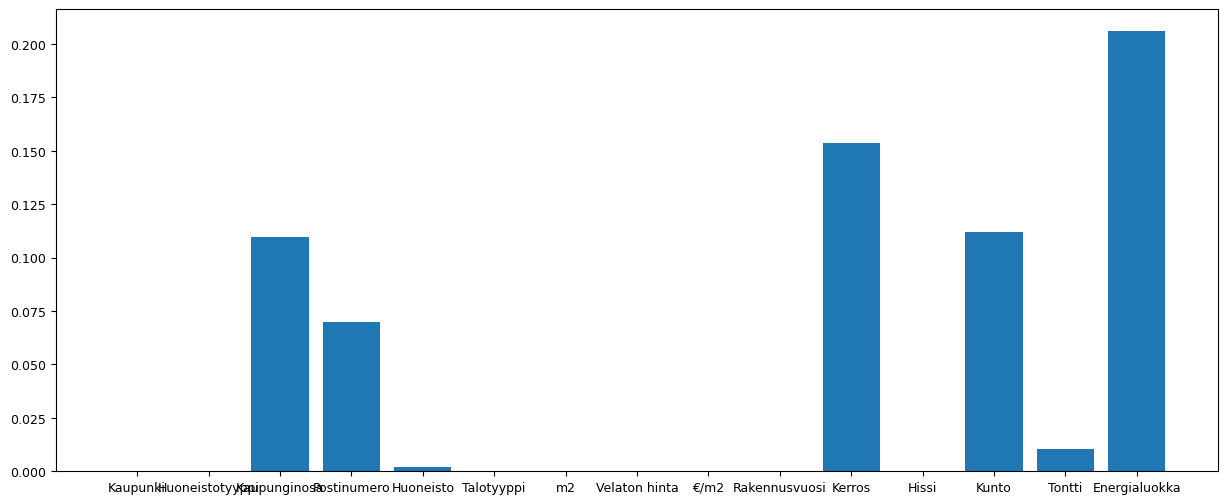

In [195]:
missing = []
for column in df:
    missing.append(df[column].isna().sum()/ (len(df.index)))

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(df.columns, missing)
#plt.rcParams['font.size'] = '16'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)

## Määritellään seuraavaksi liuta apufunktioita, joiden avulla dataa käsitellään
### Datan droppaus (ei käytössä)

In [7]:
def drop_data(data):
    
    df = data
    
    df = df.dropna(subset=['Postinumero'])      # Poistetaan postinumerottomat rivit

    df = df.drop(df[df["Huoneisto"].isna()].index)

    df = df.drop(df[np.array(df["Huoneisto"].str.match("auto.*$", case=False), dtype=bool)].index)

    df = df.drop(df[np.logical_and(np.array(df["Huoneisto"].str.match("^.*katos.*$", case=False), dtype=bool),~np.array(df["Huoneisto"].str.match("^.*[+,].*$", case=False), dtype=bool))].index)

    df = df.drop(df[np.logical_and(np.array(df["Huoneisto"].str.match("^.*piha.*$", case=False), dtype=bool),~np.array(df["Huoneisto"].str.match("^.*[+,].*$", case=False), dtype=bool))].index) # dropataan rivit, joissa puhutaan autoista, pihasta, katoksesta
    
    return df

#df = drop_data(df)

### Etsii huoneiden lukumäärän

In [8]:
def huoneisto_puhdistaja(data):

    # Some have living rooms marked seperately so taking that into account
    
    huoneiden_lkm = np.zeros(len(data["Huoneisto"]))
    data["Huoneistotyyppi"] = data["Huoneistotyyppi"].fillna("puuttuva")
    data["Huoneisto"] = data["Huoneisto"].fillna("puuttuva")
    
    # If marked as yksö => 1
    huoneiden_lkm[data["Huoneistotyyppi"].str.match("^.*Yksiö.*$", case=False)] = 1
    huoneiden_lkm[data["Huoneistotyyppi"].str.match("^.*Kaksi.*$", case=False)] = 2
    huoneiden_lkm[data["Huoneistotyyppi"].str.match("^.*Kolme.*$", case=False)] = 3
    
    oh_talot = data["Huoneisto"].str.match("^.*oh.*$", case=False)

    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(2|2h) *- *(3|3h).*$", case=False), oh_talot)] = 4
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(3|3h) *- *(4|4h).*$", case=False), oh_talot)] = 5
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(4|4h) *- *(5|5h).*$", case=False), oh_talot)] = 6
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(5|5h) *- *(6|6h).*$", case=False), oh_talot)] = 7
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(6|6h) *- *(7|7h).*$", case=False), oh_talot)] = 8
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(7|7h) *- *(8|8h).*$", case=False), oh_talot)] = 9
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(8|8h) *- *(9|9h).*$", case=False), oh_talot)] = 10
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(9|9h) *- *(10|10h).*$", case=False), oh_talot)] = 11
    
    
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(2|2h) *- *(3|3h).*$", case=False), ~oh_talot)] = 3
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(3|3h) *- *(4|4h).*$", case=False), ~oh_talot)] = 4
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(4|4h) *- *(5|5h).*$", case=False), ~oh_talot)] = 5
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(5|5h) *- *(6|6h).*$", case=False), ~oh_talot)] = 6
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(6|6h) *- *(7|7h).*$", case=False), ~oh_talot)] = 7
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(7|7h) *- *(8|8h).*$", case=False), ~oh_talot)] = 8
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(8|8h) *- *(9|9h).*$", case=False), ~oh_talot)] = 9
    huoneiden_lkm[np.logical_and(data["Huoneisto"].str.match("^.*(9|9h) *- *(10|10h).*$", case=False), ~oh_talot)] = 10
    
    #what does 2-4h mean. But I'll go with the higher value
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(2|2h) *- *(4|4h).*$", case=False)] = 4
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(3|3h) *- *(5|5h).*$", case=False)] = 5
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(4|4h) *- *(6|6h).*$", case=False)] = 6
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(5|5h) *- *(7|7h).*$", case=False)] = 7
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(6|6h) *- *(8|8h).*$", case=False)] = 8
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(7|7h) *- *(9|9h).*$", case=False)] = 9
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(8|8h) *- *(10|10h).*$", case=False)] = 10
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(9|9h) *- *(11|11h).*$", case=False)] = 11
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(10|210h) *- *(12|12h).*$", case=False)] = 12

    #Special ones I Found
    huoneiden_lkm[data["Huoneisto"].str.match("^.*(4|4h) *- *(7|7h).*$", case=False)] = 7

    huoneiden_lkm[data["Huoneisto"].str.match("^.*3\(-4\)h.*$", case=False)] = 4
    huoneiden_lkm[data["Huoneisto"].str.match("^.*4\(-5\)h.*$", case=False)] = 5

    huoneiden_lkm[data["Huoneisto"].str.match("^.*3 *\(4\).*$", case=False)] = 4
    huoneiden_lkm[data["Huoneisto"].str.match("^.*4 *\(5\).*$", case=False)] = 5
    huoneiden_lkm[data["Huoneisto"].str.match("^.*5 *\(6\).*$", case=False)] = 6
    
    # Those who have living rooms seperately
    for i in range(15):
        regex="^.*%i *h.*$"%i

        # eg. huoneisto has 3h or 3 h anywhere AND huoneiden_lkm hasn't been assigned AND it has "oh" somewhere
        huoneiden_lkm[np.logical_and(
            data["Huoneisto"].str.match(regex, case=False), 
            np.logical_and(huoneiden_lkm == 0, data["Huoneisto"].str.match("^.*oh.*$", case=False)
        ))] = i+1

    # With mh mark
    for i in range(15):
        regex="^.*%i *mh.*$"%i

        # eg. huoneisto has 3h or 3 h anywhere AND huoneiden_lkm hasn't been assigned AND it has "oh" somewhere
        huoneiden_lkm[np.logical_and(
            data["Huoneisto"].str.match(regex, case=False), 
            np.logical_and(huoneiden_lkm == 0, data["Huoneisto"].str.match("^.*oh.*$", case=False)
        ))] = i+1

    # Non livingrooms
    for i in range(15):
        regex="^.*%i *h.*$"%i

        # eg. huoneisto has 3h or 3 h anywhere AND huoneiden_lkm hasn't been assigned AND it does NOT have "oh" somewhere
        huoneiden_lkm[np.logical_and(
            data["Huoneisto"].str.match(regex, case=False), 
            np.logical_and(huoneiden_lkm == 0, ~data["Huoneisto"].str.match("^.*oh.*$", case=False)
        ))] = i
        
        # Since there are only "Neljä huonetta tai enemmän" left to process, so those with [0-3]mh are probabply 4
    for i in range(4):
        regex="^.*%i *mh.*$"%i


        huoneiden_lkm[np.logical_and(
            data["Huoneisto"].str.match(regex, case=False), 
            np.logical_and(huoneiden_lkm == 0, ~data["Huoneisto"].str.match("^.*oh.*$", case=False)
        ))] = i
        
    # More sepcial ones that I found
    huoneiden_lkm[data["Huoneisto"].str.match("4,.*$", case=False)] = 4
    huoneiden_lkm[data["Huoneisto"].str.match("4\+.*$", case=False)] = 4
    
    return pd.Series(huoneiden_lkm, index = data.index)


### Etsii onko huoneistossa saunaa

In [9]:
def parsija(text):
    text = str(text)
    #text = text.replace(" ", "") # Poistaa whitespacet kaikkialta
    text = ','.join(text.split(',')[1:]) # Poistaa tavaran ensimmäistä pilkkua
    text = text.strip() # poistaa alun ja lopun whitespacet
    #text = text.replace(",", " ")
    text = re.sub('[^A-Za-z0-9]+', ',', text) # poistaa erikoismerkit ja korvaa ne pilkulla
    text = text.split(",")  #splitataan pilkkujen mukaan
    
    temp = []
    for sana in text:
         temp.append(re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", sana).strip())   # lisätään välilyönti numeroiden ja sanojen väliin

    text = (temp)
    
    text = list(filter(None, text)) # Poistetaan tyhäjt stringit listasta

    text = pd.DataFrame(text)
    dct = {
           '^tup.*' : 'tupakeittiö',
           '^avok*' : 'avokeittiö',
           '^al.*' : 'alkovi', 
           r'(?i)\b[s]\b' : 'sauna',
           '^vh.*' : 'vierashuone',
           r'(?i)\b[k]\b' : 'keittiö',
           '^khh.*' : 'kodinoitohuone',
           '^kh.*' : 'kylpyhuone',
           '^kph.*' : 'kylpyhuone',
           '^kp.*' : 'kylpyhuone',
           '^kk.*' : 'keittokomero',
           '^apuk.*' : 'apukeittiö',
           '^var*' : 'varasto',
           '^mh*' : 'makuuhuone',           
           '^oh*' : 'olohuone',
           r'(?i)\b[kt]\b' : 'keittiö',
           '^parve*' : 'parveke',
           r'(?i)\b[p]\b' : 'parveke',
           r'(?i)\b[pa]\b' : 'parveke',
           r'(?i)\b[par]\b' : 'parveke',
           '^las*' : 'lasitettu parveke',
           '^pesuh*' : 'pesuhuone',
           '^psh*' : 'pesuhuone',
           r'(?i)\b[psh]\b' : 'pesuhuone',
           r'(?i)\b[kt.]\b' : 'keittiö',
           r'(?i)\b[kt ]\b' : 'keittiö',
           r'(?i)\b[th]\b' : 'työhuone',
           
           
          }

    text.replace(dct, regex = True, inplace = True)
    
    testattava = 0
    sanat = 'sauna'
    if sanat in str(text).lower():    
        testattava = 1
    
    

    return testattava 

#df.Huoneisto.apply(parsija)
    

### Splittaa kerrokset kahtia ja siivoaa ne samalla

In [10]:
def kerros_split(kerros):
    
    try:
        kerros_data = kerros.split('/')
        alempi = int(kerros_data[0])
        ylempi = int(kerros_data[1])
    except:
        alempi, ylempi = 0, 0
    
    if alempi > ylempi:
        alempi, ylempi = 0, 0
    if alempi < 0:
        alempi, ylempi = 0, 0
    if ylempi < 0:
        alempi, ylempi = 0, 0
    return alempi

def kerros_split_max(kerros):
    
    try:
        kerros_data = kerros.split('/')
        alempi = int(kerros_data[0])
        ylempi = int(kerros_data[1])
    except:
        alempi, ylempi = 0, 0
    
    if alempi > ylempi:
        alempi, ylempi = 0, 0
    if alempi < 0:
        alempi, ylempi = 0, 0
    if ylempi < 0:
        alempi, ylempi = 0, 0
    return ylempi

## Funktio, joka kutsuu apufunktioita ja palauttaa niiden avulla puhdistetun dataframen

In [11]:
def imputer(df):
    
    #df = drop_data(df)
    
    # apufunktio imputoimiseen, etsii yleisimmän entryn listasta
    def most_frequent(List):
        try:
            return max(set(List), key = List.count)
        except:
            return str("NAN")
            
            
    # Energialuokka
    
    def e_imputer(e_class):
        e_class = str(e_class)
        if(e_class[0] == 'A'):
            return 1
        if(e_class[0] == 'B'):
            return 2
        if(e_class[0] == 'C'):
            return 3
        if(e_class[0] == 'D'):
            return 4
        if(e_class[0] == 'E'):
            return 5
        if(e_class[0] == 'F'):
            return 6
        
    Energial = df["Energialuokka"].apply(e_imputer).fillna(7)
    
    
    # Kunto
    
        # Oletetaan, että kunnon puuttuminen on indikaattori kunnosta, eli NAN fillaaminen voisi olla ok päätös. Muuttuja ei korreloinut muiden muuttuhien kanssa.
        #Kunto = df["Kunto"].fillna("NAN")
    
    mask = df["Kunto"].isna() # muodostetaan maski puuttuvista energialuokituksista
    puuttuvien_vuodet = list(df["Rakennusvuosi"][mask]) # käytetään maskia lukemaan rakennusvuodet puuttuvilta energialuokitus kohteilta
    def kunto_imputer(kunto_class):
        if pd.isna(kunto_class) == 1:
            if(puuttuvien_vuodet.pop(0) > 2017): # Jos asunnon kunto puuttuu, imputoidaan se hyväksi, jos talo on uudempi kuin 2017, muuten tuntematon kunto
                return "hyvä"
            else:
                return "tyyd."
        else:
            return kunto_class # Jos ei puutu, OK    
    
    def Kunto_num(kunto):
        if kunto == 'hyvä':
            return 2
        if kunto == 'tyyd.':
            return 1
        if kunto == 'huono':
            return 0
        
    Kunto = df["Kunto"].apply(kunto_imputer).apply(Kunto_num)
    
    # Tontti
    
        # Fillataan tontti talotyypin tonttien mediaanilla
    mask = df["Tontti"].isna()
    puuttuvien_talot = list(df["Talotyyppi"][mask])    
    def t_imputer(t_class):
        if pd.isna(t_class) == 1:
            return most_frequent(list(df["Tontti"][df.Talotyyppi == puuttuvien_talot.pop(0)].dropna()))
        else:
            return t_class
        
    def Tontti_bin(tontti):
        if tontti == 'oma':
            return 1
        if tontti == 'vuokra':
            return 0
        
    Tontti = df["Tontti"].apply(t_imputer).apply(Tontti_bin)
    
    # Huoneisto
    
    Huoneisto = df["Huoneisto"].apply(parsija) # testaa saunalle
    
    Huoneisto = Huoneisto.fillna("Puuttuva huoneisto")
    Huone_lkm = huoneisto_puhdistaja(df)
    
    # Kerrokset

    Kerros = df["Kerros"].apply(kerros_split)
    Kerros_max = pd.DataFrame(df["Kerros"].apply(kerros_split_max))
    
    # Hissi
    
    def Hissi_bin(text):
        if text == 'on':
            return 1
        if text == 'ei':
            return 0
            
    Hissi = df["Hissi"].apply(Hissi_bin)
    
    # Postinumero
    
    Postinumero = df["Postinumero"].fillna(np.mean(df.Postinumero))
    
    # Rakennusvuosi
    
    Rakennusvuosi = df["Rakennusvuosi"].apply(int)
    
    # m2
    
    m2 = df["m2"]
    
    # Talotyyppi
    
    Talotyyppi = df["Talotyyppi"]
    
    to_name = pd.concat([Talotyyppi, Postinumero, Huoneisto, m2,  Rakennusvuosi, Kerros, Kerros_max, Hissi, Kunto, Tontti, Energial, Huone_lkm]
                      # df["Huoneistotyyppi"]
                      , axis = 1)

    to_name.columns = ["Talotyyppi", "Postinumero", "Sauna", "m2",  "Rakennusvuosi", "Kerros", "Kerros_max", "Hissi", "Kunto", "Tontti", "Energial", "Huone_lkm"]
    
    return to_name


## Column transformerit pipelineä varten

In [ ]:
ct = make_column_transformer(
    (MyCategoricalTransformer(), ["Postinumero",	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]),
    remainder = 'drop',
    n_jobs = -1
)

# FunctionTransformer(imputer) # testin ajaksi pois

# ["Postinumero",	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]

ct_2 = make_column_transformer(
    (OneHotEncoder(sparse = False , handle_unknown = 'ignore'), [0]),
    remainder = 'passthrough',
    n_jobs = -1
)

ct_0 = make_column_transformer(
    (FunctionTransformer(drop_data), ["Postinumero",	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]),
    remainder = 'drop',
    n_jobs = -1
)

ct_2.fit_transform(ct.fit_transform(df.sample(50))).shape # testaus transformereista

## Pipelinet, joka puhdistaa datan column transformerien avulla ja sovittaa sitten mallin

In [135]:
metsä = Pipeline(
    [
    ('parsing', ct),
    ('ohe', ct_2),
    ('forest', RandomForestRegressor(n_jobs = -1, n_estimators = 350, max_depth = 20, max_features = 0.8, warm_start = True))
    ]
)

cat = Pipeline(
    [
    ('parsing', ct),
    ('ohe', ct_2),
    ('cat', CatBoostRegressor(thread_count=10, od_type='IncToDec', silent = True))
    ]
)

ada = Pipeline(
    [
    ('parsing', ct),
    ('ohe', ct_2),
    ('ada', AdaBoostRegressor(n_estimators = 100, learning_rate = 0.05, loss = "square"))
    ]
)

gb = Pipeline(
    [
    ('parsing', ct),
    ('ohe', ct_2),
    ('gb', GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.05, loss = "squared_error", max_depth = 6))
    ]
)


In [136]:
metsä.fit(X_train, y_train)
print(metsä.score(X_test, y_test))
print(np.mean([est.get_n_leaves() for est in metsä['forest'].estimators_ ]))

0.840646872734207
11299.065714285714


In [137]:
cat.fit(X_train, y_train)
cat.score(X_test, y_test)

0.8586565823281375

In [138]:
ada.fit(X_train, y_train)
ada.score(X_test, y_test)

0.5279875924873694

In [139]:
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.8395457543153713

## Catboostin tarkastelua

In [133]:
np.mean(cross_val_score(cat, X_train, y_train, n_jobs=-1)) # cross-val R^2 on train data

0.8597010100433412

In [140]:
cat.score(X_train, y_train)

0.9281163369110822

In [141]:
cat['cat'].tree_count_

1000

In [142]:
cat['cat'].learning_rate_

0.06638900190591812

In [143]:
importance = cat['cat'].feature_importances_
 
names = ["taloO", "taloR", "taloK", "Postinumero", "Sauna", "m2",  "Rakennusvuosi", "Kerros", "Kerros_max", "Hissi", "Kunto", "Tontti", "Energial", "Huone_lkm"]

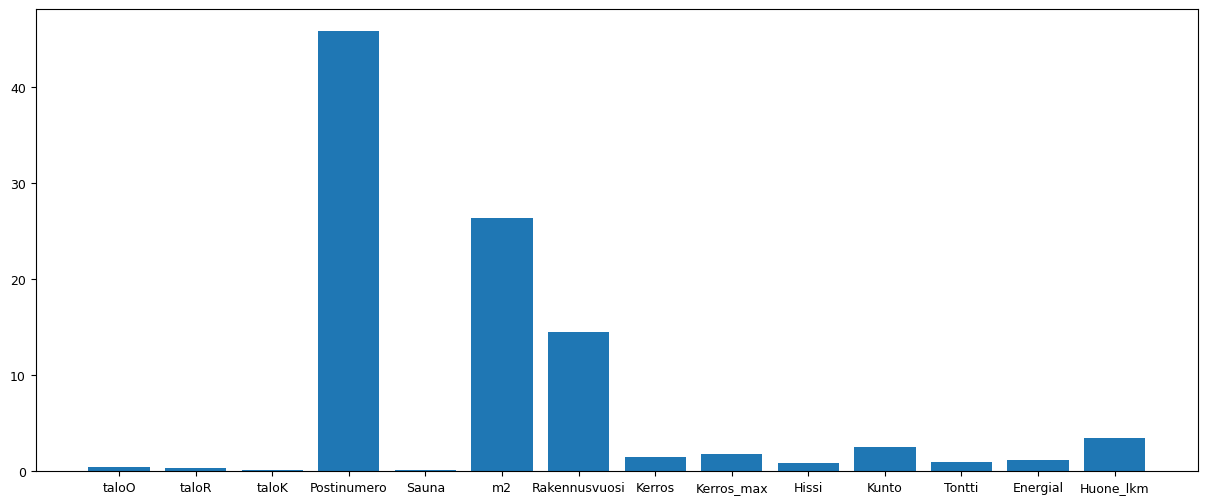

In [144]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(names, importance)
#plt.rcParams['font.size'] = '16'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(9)

## Mallien pikkelöinti ensemble mallia varten

In [112]:
filename = 'CatBoost_JR_finalized_model.mod' 

# save the model to disk

pickle.dump(cat, open(filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))

In [107]:
filename = 'RandomForest_JR_finalized_model.mod' 

# save the model to disk

pickle.dump(metsä, open(filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))

In [127]:
filename = 'GB_JR.mod' 

# save the model to disk

pickle.dump(gb, open(filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))